In [454]:
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection modules
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from scipy import stats

# Encoding modules
import category_encoders as ce

# Feature transformation modules
from sklearn import preprocessing

# Data splitting modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning modules
from sklearn.model_selection import GridSearchCV

# Model evaluation modules
from sklearn import metrics
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [455]:
RANDOM_NUM = 42

# 1. Data Overview

Feautres description:

- trans_date_trans_time ------- Transaction time stamp

- cc_num ---------------------- Credit card number

- merchant -------------------- Merchant name

- category -------------------- Transaction category

- amt ------------------------- Transaction amount

- first ----------------------- First name of card holder

- last ------------------------ Last name of card holder

- gender ---------------------- Sex of card holder

- street ---------------------- Transaction adress

- city ------------------------ Transaction city

- state ----------------------- Transaction state

- zip ------------------------- Transaction zipcode

- lat ------------------------- Transaction lattitude

- long ------------------------ Transaction longtitude 

- city_pop -------------------- Population of the city

- job ------------------------- Job of the card holder

- dob ------------------------- Date of birth of card holder

- trans_num ------------------- Transaction number of transaction

- unix_time ------------------- Time in unix format

- merch_lat ------------------- Lattitude of the merchant

- merch_long ------------------ Longitude of merchant

- is_fraud -------------------- fraud mark of transaction


In [456]:
# load the dataset
test_data = pd.read_csv('data/fraudTest.csv')
train_data = pd.read_csv('data/fraudTrain.csv')

In [457]:
train_data.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [458]:
# Unnamed column drop
train_data = train_data.drop(['Unnamed: 0'], axis=1)
test_data = test_data.drop(['Unnamed: 0'], axis=1)
train_data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [459]:
# Overal data information analysis 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

Тренировочный набор данных содержит 1 296 674 наблюдений и 22 признака (включая целевой - is_fraud). 

# 2. Data pre-processing

In [460]:
# Feautures type transformation
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
train_data['dob'] = pd.to_datetime(train_data['dob'])
train_data['zip'] = train_data['zip'].astype(dtype='string')

In [461]:
def add_datetime_features(data):
    """
    Function for adding date features such as:
    transaction month, day of week, hour and age of cardholder

    Args:
        data (DataFrame): Original dataset

    Returns:
        data (DataFrame): Modified dataset
    """
    data['trans_month_of_year'] = data['trans_date_trans_time'].dt.month
    data['trans_day_of_week'] = data['trans_date_trans_time'].dt.day_of_week
    data['trans_hour'] = data['trans_date_trans_time'].dt.hour
    data['age_of_cardholder'] = np.round((data['trans_date_trans_time'] - data['dob']) / np.timedelta64(1, 'Y'))
    data = data.drop(['trans_date_trans_time'], axis=1)
    return data

In [462]:
# Adding date features
pre_processed_data = add_datetime_features(train_data)

# 3. Exploratory Data Analysis

## 3.1. Target feature analysis

In [463]:
# Analysis of the balance of classes of the target variable
pre_processed_data.is_fraud.value_counts(normalize=True) * 100

0    99.421135
1     0.578865
Name: is_fraud, dtype: float64

In [464]:
# Analysis of transaction volumes by target variable classes
trans_sum  = pre_processed_data[['amt', 'is_fraud']].groupby(['is_fraud']).sum().reset_index().rename(columns={'amt':'trans_sum'})
trans_sum['percentage'] = trans_sum['trans_sum'] / trans_sum['trans_sum'].sum() * 100
trans_sum

,is_fraud,trans_sum,percentage
0,0,87234340.29,95.628171
1,1,3988088.61,4.371829


Как показывает выполненный анализ в данных присутствует дисбаланс классов.
- Классом большинства (можаритарный класс) является - не мошенническая транзакция (99,48% от общего числа транзакций в данных)
- Классом меньшинства (миноритарный класс) является - мошенническая транзакция (0,52% от общего числа транзакций в данных)
- С точки зрения объемов мошеннические операции составляют порядка 4% от общих объемов транзакций.

При построении моделей необходимо использовать различные методы уменьшения влияния дисбаланса на обучение моделей, такие как: взвешивание объектов, выбор порога вероятности, сэмплирование.

## 3.2 Transaction amount feature analysis

In [465]:
# Transaction amount feature analysis
overall_amount = pre_processed_data['amt'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'amt': 'overall amount'})
is_fraud_amount = pre_processed_data[pre_processed_data['is_fraud'] == 1]['amt'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'amt':'is_fraud amount'})
non_fraud_amount = pre_processed_data[pre_processed_data['is_fraud'] == 0]['amt'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'amt':'non_fraud amount'})
amount_distribution = pd.concat([overall_amount, is_fraud_amount.drop(['description'], axis=1), non_fraud_amount.drop(['description'], axis=1)], axis=1).reset_index(drop=1)
amount_distribution

,description,overall amount,is_fraud amount,non_fraud amount
0,count,1.296675e+06,7506.000000,1.289169e+06
1,mean,7.035104e+01,531.320092,6.766711e+01
2,std,1.603160e+02,390.560070,1.540080e+02
3,min,1.000000e+00,1.060000,1.000000e+00
4,25%,9.650000e+00,245.662500,9.610000e+00
5,50%,4.752000e+01,396.505000,4.728000e+01
6,75%,8.314000e+01,900.875000,8.254000e+01
7,99%,5.459926e+02,1179.690000,4.863032e+02
8,max,2.894890e+04,1376.040000,2.894890e+04


По результатам анализа распределения признака величины транзкации в зависимости от метки о мошенничестве сделаны следующие выводы:
- Общее количество операций, помеченных как мошеннические, составляет 7506 единица.
- Показатель среднего арифметического для распределения величины мошеннических транзакций на порядок превосходит аналогичный показатель не мошеннических транзакций (531,2 против 67,8).
- Максимальное значение величины мошеннических транзакцией составляет 1376.

Для наглядности визуализации распределения признака величины транзакции в качестве ограничение принято значение 1500.

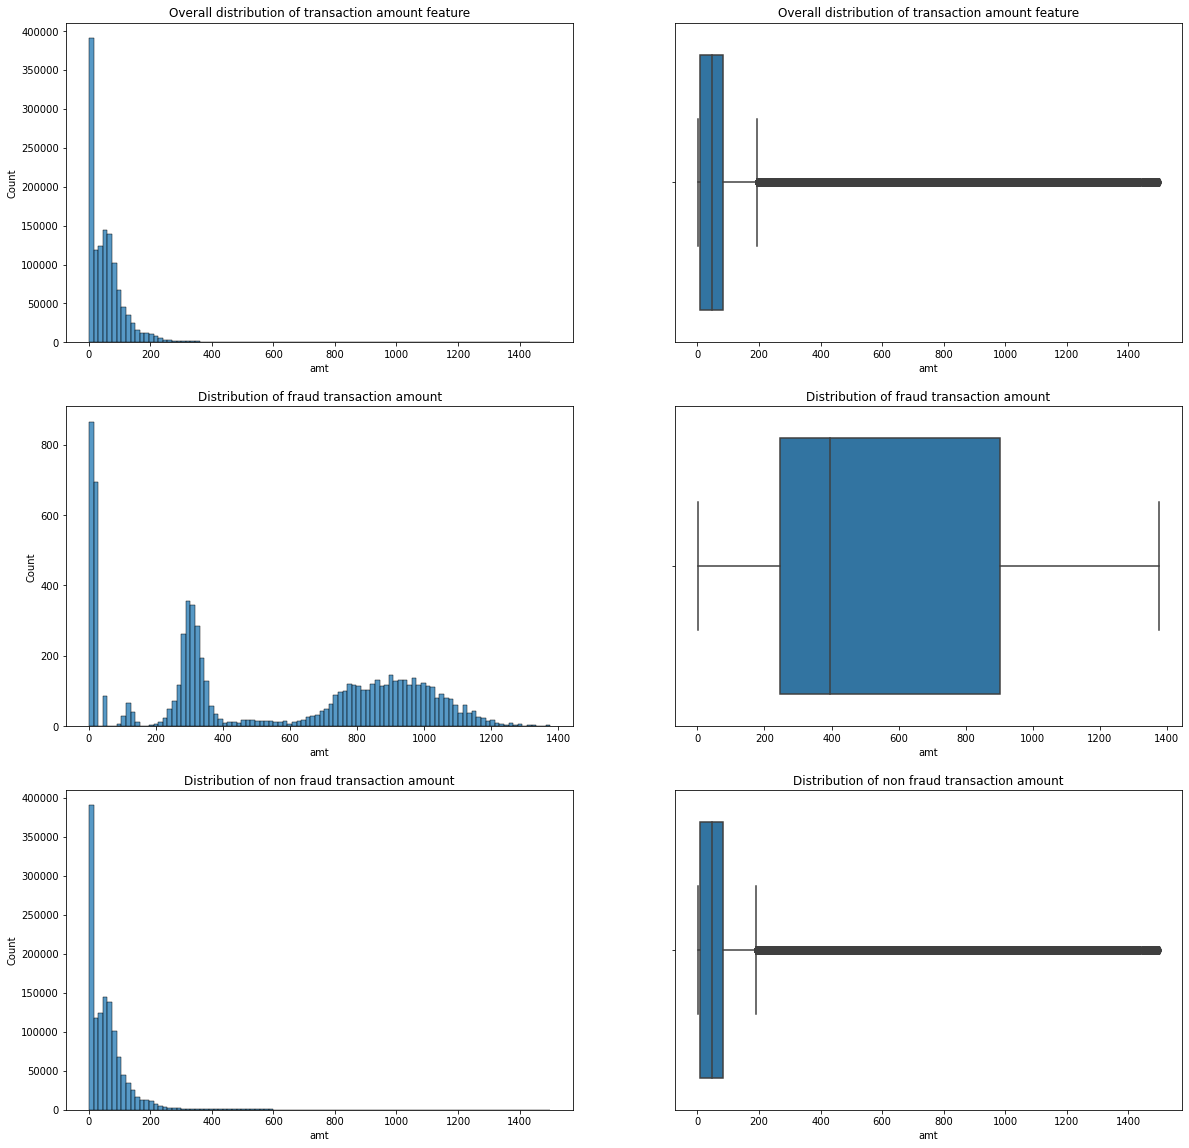

In [466]:
# Histogram and box plot visualisation of transaction amount feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
histplot = sns.histplot(data=pre_processed_data[(pre_processed_data.amt <= 1500)], x='amt', ax=axes[0][0], bins=100)
histplot.set_title('Overall distribution of transaction amount feature')
boxplot = sns.boxplot(data=pre_processed_data[(pre_processed_data.amt <= 1500)], x='amt', ax=axes[0][1])
boxplot.set_title('Overall distribution of transaction amount feature')

histplot = sns.histplot(data=pre_processed_data[(pre_processed_data.amt <= 1500) & (pre_processed_data.is_fraud == 1)], x='amt', ax=axes[1][0], bins=100)
histplot.set_title('Distribution of fraud transaction amount')
boxplot = sns.boxplot(data=pre_processed_data[(pre_processed_data.amt <= 1500) & (pre_processed_data.is_fraud == 1)], x='amt', ax=axes[1][1])
boxplot.set_title('Distribution of fraud transaction amount');

histplot = sns.histplot(data=pre_processed_data[(pre_processed_data.amt <= 1500) & (pre_processed_data.is_fraud == 0)], x='amt', ax=axes[2][0], bins=100)
histplot.set_title('Distribution of non fraud transaction amount')
boxplot = sns.boxplot(data=pre_processed_data[(pre_processed_data.amt <= 1500) & (pre_processed_data.is_fraud == 0)], x='amt', ax=axes[2][1])
boxplot.set_title('Distribution of non fraud transaction amount');

In [467]:
# Выполнение теста на нормальность
# Формулировка нулевой и альтернативной гипотез
H0 = 'Распределение признака amt является нормальным'
H1 = 'Распределение признака amt отлично от нормального'

# Уровень значимости
alpha = 0.05

# Выполнение теста Д'Агостино
d_agostino = stats.normaltest(pre_processed_data['amt'])

if d_agostino.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу. Распределение признака amt является нормальным
Альтернативная гипотеза. H1: Распределение признака amt отлично от нормального


По результатам анализа визуализации распределения признака величины транзкации в зависимости от метки о мошенничестве сделаны следующие выводы:
- Основная часть наблюдение признака величины не мошеннических транзакций лежит в пределах от 0 до 100.
- В наборе данных наблюдаются множетсвенные выбросы.
- Распределение мошеннических транзакции более равномерно чем не мошеннических.

## 3.3 Age of card holder feature analysis

In [468]:
# Age of cardholder feature analysis
overall_age = pre_processed_data['age_of_cardholder'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'age_of_cardholder': 'overall age_of_cardholder'})
is_fraud_age = pre_processed_data[pre_processed_data['is_fraud'] == 1]['age_of_cardholder'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'age_of_cardholder':'is_fraud age_of_cardholder'})
non_fraud_age = pre_processed_data[pre_processed_data['is_fraud'] == 0]['age_of_cardholder'].describe(percentiles=[0.25, 0.5, 0.75, 0.99]).reset_index().rename(columns={'index':'description', 'age_of_cardholder':'non_fraud age_of_cardholder'})
age_distribution = pd.concat([overall_age, is_fraud_age.drop(['description'], axis=1), non_fraud_age.drop(['description'], axis=1)], axis=1).reset_index(drop=1)
age_distribution

,description,overall age_of_cardholder,is_fraud age_of_cardholder,non_fraud age_of_cardholder
0,count,1.296675e+06,7506.000000,1.289169e+06
1,mean,4.599986e+01,48.797762,4.598357e+01
2,std,1.739626e+01,18.868510,1.738601e+01
3,min,1.400000e+01,14.000000,1.400000e+01
4,25%,3.300000e+01,33.000000,3.300000e+01
5,50%,4.400000e+01,48.000000,4.400000e+01
6,75%,5.700000e+01,61.000000,5.700000e+01
7,99%,9.100000e+01,92.000000,9.100000e+01
8,max,9.600000e+01,94.000000,9.600000e+01


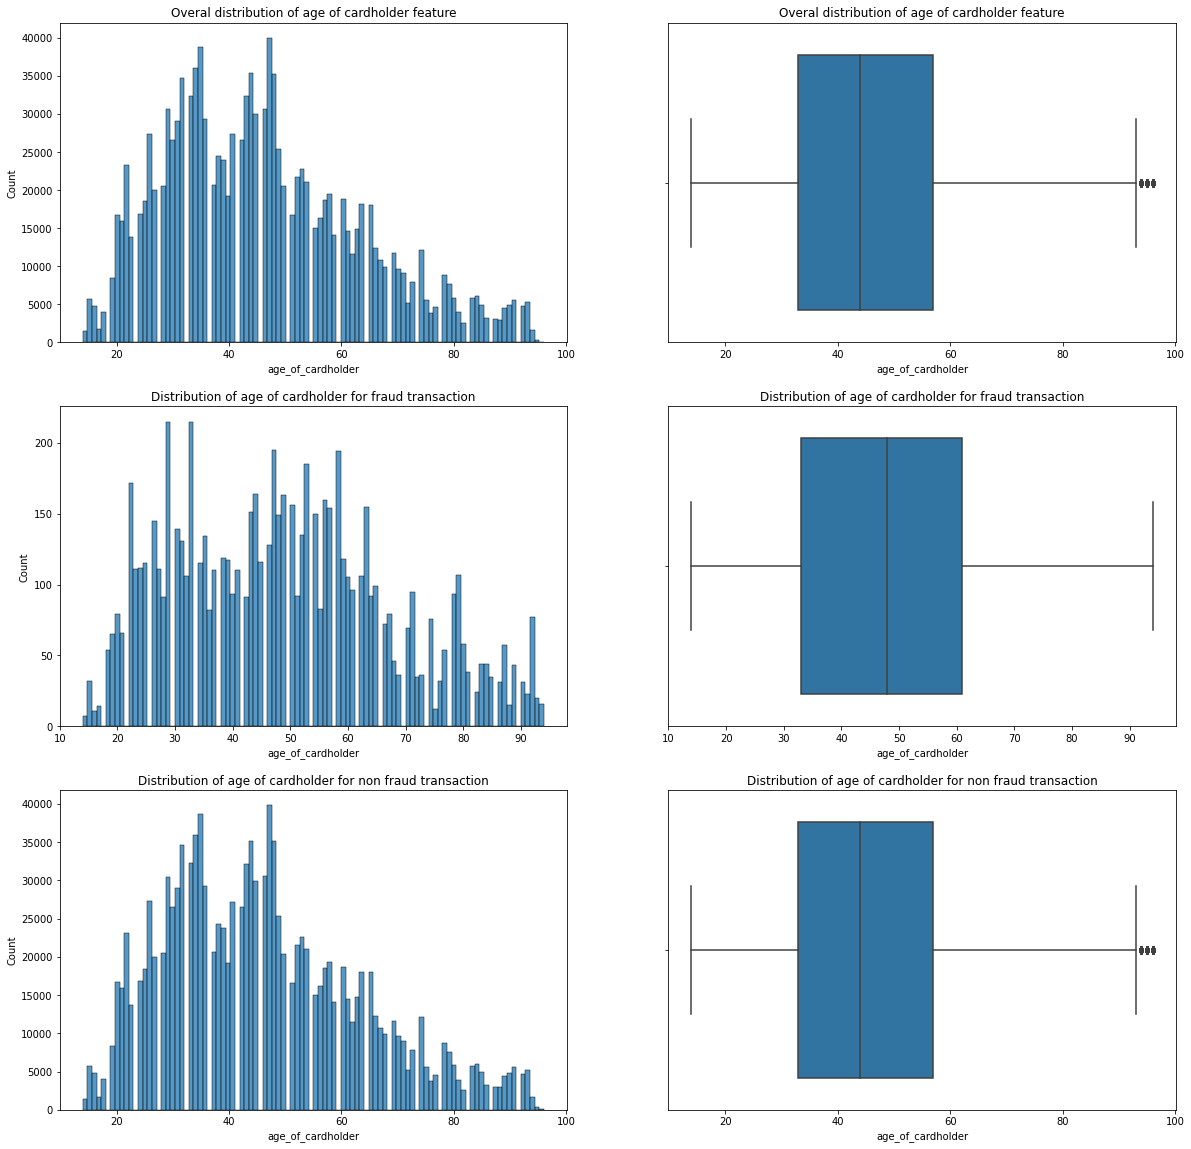

In [469]:
# Histogram and box plot visualisation of age of cardholder feature
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
histplot = sns.histplot(data=pre_processed_data, x='age_of_cardholder', ax=axes[0][0], bins=100)
histplot.set_title('Overal distribution of age of cardholder feature')
boxplot = sns.boxplot(data=pre_processed_data, x='age_of_cardholder', ax=axes[0][1])
boxplot.set_title('Overal distribution of age of cardholder feature');

histplot = sns.histplot(data=pre_processed_data[pre_processed_data.is_fraud == 1], x='age_of_cardholder', ax=axes[1][0], bins=100)
histplot.set_title('Distribution of age of cardholder for fraud transaction')
boxplot = sns.boxplot(data=pre_processed_data[pre_processed_data.is_fraud == 1], x='age_of_cardholder', ax=axes[1][1])
boxplot.set_title('Distribution of age of cardholder for fraud transaction');

histplot = sns.histplot(data=pre_processed_data[pre_processed_data.is_fraud == 0], x='age_of_cardholder', ax=axes[2][0], bins=100)
histplot.set_title('Distribution of age of cardholder for non fraud transaction')
boxplot = sns.boxplot(data=pre_processed_data[pre_processed_data.is_fraud == 0], x='age_of_cardholder', ax=axes[2][1])
boxplot.set_title('Distribution of age of cardholder for non fraud transaction');

In [470]:
def add_age_group(age):
    """
    Function for adding age group of cardholders

    Args:
        age (float): Age of cardholder

    Returns:
        string: Cardholders age group
    """
    if age <= 30:
        return '< 30'
    elif age > 30 and age <= 45:
        return '30-45'
    elif age > 45 and age <= 60:
        return '45-60'
    else:
        return '> 60'

In [471]:
# Adding of cardholders age group
pre_processed_data['age_group'] = pre_processed_data['age_of_cardholder'].apply(add_age_group)

In [472]:
# Age groupe of cardholder feature analysis
overal_age_grouped = pre_processed_data[['age_group', 'trans_num']].groupby(['age_group']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_age_grouped = pre_processed_data[['age_group', 'trans_num', 'is_fraud']].groupby(['age_group', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_age_grouped = fraud_age_grouped.merge(overal_age_grouped, how='inner', on='age_group')
merged_age_grouped['percentage'] = merged_age_grouped['fraud trans_count'] / merged_age_grouped['trans_count'] * 100
merged_age_grouped

,age_group,is_fraud,fraud trans_count,trans_count,percentage
0,30-45,0,438557,440411,99.579030
1,30-45,1,1854,440411,0.420970
2,45-60,0,334647,336814,99.356618
3,45-60,1,2167,336814,0.643382
4,< 30,0,255220,256759,99.400605
5,< 30,1,1539,256759,0.599395
6,> 60,0,260745,262691,99.259206
7,> 60,1,1946,262691,0.740794


По результатам анализа распределения признака возвраста владельца карты в зависимости от метки о мошенничестве сделаны следующие выводы:
- Среднее значение возвраста владельцев карт мошеннических транзакций больше среднего значений владельцев карт не мошеннических транзакций (48.8 против 46 лет)
- Наибольший процент мошеннических транзакций наблюдается в возрастной группе более 60 лет (0.74% от общего числа транзакций по группе).
- Наименьший процент мошеннических транзакций наблюдается в возрастной группе от 30 до 45 лет (0.42% от общего числа транзакций по группе).


## 3.4 Gender of card holder feature analysis

In [473]:
# Cardholder gender feature analysis
overal_gender_grouped = pre_processed_data[['gender', 'trans_num']].groupby(['gender']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_gender_grouped = pre_processed_data[['gender', 'trans_num', 'is_fraud']].groupby(['gender', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_gender_grouped = fraud_gender_grouped.merge(overal_gender_grouped, how='inner', on='gender')
merged_gender_grouped['percentage'] = merged_gender_grouped['fraud trans_count'] / merged_gender_grouped['trans_count'] * 100
merged_gender_grouped

,gender,is_fraud,fraud trans_count,trans_count,percentage
0,F,0,706128,709863,99.473842
1,F,1,3735,709863,0.526158
2,M,0,583041,586812,99.357375
3,M,1,3771,586812,0.642625


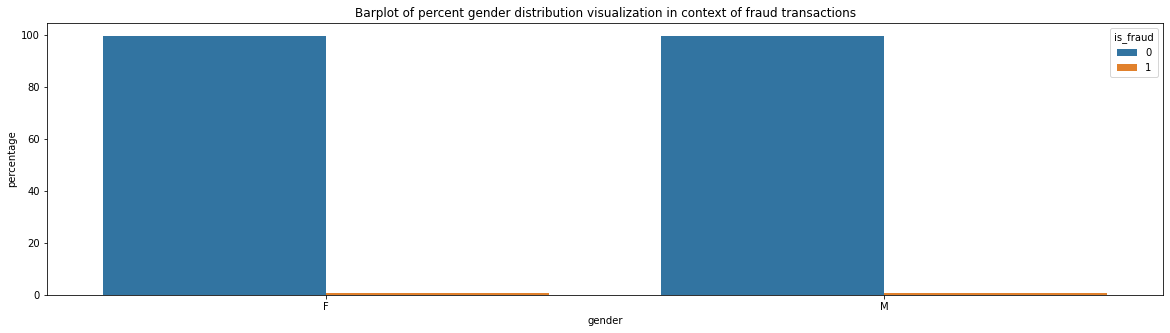

In [474]:
# Barplot of gender distribution visualization
fig, axes = plt.subplots(figsize=(20, 5))
barplot = sns.barplot(data=merged_gender_grouped, x='gender', y='percentage', hue='is_fraud', ax=axes)
axes.set_title('Barplot of percent gender distribution visualization in context of fraud transactions');

По результатам анализа распределения признака пола владельца карты в зависимости от метки о мошенничестве сделаны следующие выводы:
- Наибольший процент мошеннических транзакций наблюдается в группе мужчин (0.64% от общего числа транзакций по группе).
- Мужчины более вовлечены в мошеннические операции (процент мошеннических операций на 20% больше чем в женской группе).

## 3.5 Job feature analysis

In [475]:
# Descriptive statistics of job feature
pre_processed_data.job.describe()

count               1296675
unique                  494
top       Film/video editor
freq                   9779
Name: job, dtype: object

In [476]:
# Cardholder job feature analysis
overal_job_grouped = pre_processed_data[['job', 'trans_num']].groupby(['job']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_job_grouped = pre_processed_data[['job', 'trans_num', 'is_fraud']].groupby(['job', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_job_grouped = fraud_job_grouped.merge(overal_job_grouped, how='inner', on='job')
merged_job_grouped['percentage'] = merged_job_grouped['fraud trans_count'] / merged_job_grouped['trans_count'] * 100
merged_job_grouped

,job,is_fraud,fraud trans_count,trans_count,percentage
0,Academic librarian,0,1030,1041,98.943324
1,Academic librarian,1,11,1041,1.056676
2,"Accountant, chartered",1,11,11,100.000000
3,"Accountant, chartered certified",0,525,534,98.314607
4,"Accountant, chartered certified",1,9,534,1.685393
...,...,...,...,...,...
913,Web designer,1,18,2556,0.704225
914,Wellsite geologist,0,2581,2601,99.231065
915,Wellsite geologist,1,20,2601,0.768935
916,Writer,0,489,504,97.023810


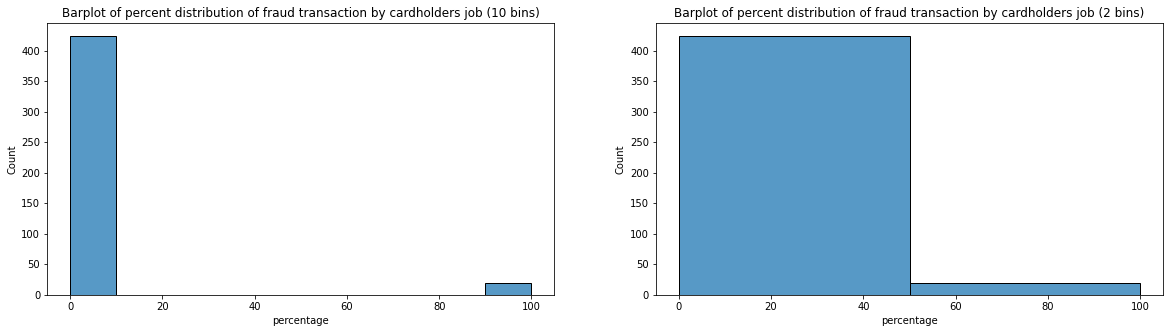

In [477]:
# Barplot of distribution of fraud transaction by cardholders job
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_job_grouped[merged_job_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Barplot of percent distribution of fraud transaction by cardholders job (10 bins)')
histplot_2 = sns.histplot(merged_job_grouped[merged_job_grouped.is_fraud == 1].percentage, bins=2, ax=axes[1])
axes[1].set_title('Barplot of percent distribution of fraud transaction by cardholders job (2 bins)');

In [478]:
# List of high risk job
high_risk_job = merged_job_grouped[(merged_job_grouped.is_fraud == 1) & (merged_job_grouped.percentage >= 90)].job.to_list()

По результатам анализа признака професии в зависимости от метки о мошенничестве сделаны следующие выводы:
- Для большинства профессий процент мошеннических транзакций лежит в диапазоне от 0 до 50 процентов
- Для некоторых профессий отмечается высокая доля мошеннических транзакций (high_risk_job)

Для профессий с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

## 3.6 Category transaction feature analysis

In [479]:
# Descriptive statistics of transaction category feature
pre_processed_data.category.describe()

count           1296675
unique               14
top       gas_transport
freq             131659
Name: category, dtype: object

In [480]:
# Transaction category feature analysis
overal_category_grouped = pre_processed_data[['category', 'trans_num']].groupby(['category']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_category_grouped = pre_processed_data[['category', 'trans_num', 'is_fraud']].groupby(['category', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_category_grouped = fraud_category_grouped.merge(overal_category_grouped, how='inner', on='category')
merged_category_grouped['percentage'] = merged_category_grouped['fraud trans_count'] / merged_category_grouped['trans_count'] * 100
merged_category_grouped

,category,is_fraud,fraud trans_count,trans_count,percentage
0,entertainment,0,93781,94014,99.752165
1,entertainment,1,233,94014,0.247835
2,food_dining,0,91310,91461,99.834902
3,food_dining,1,151,91461,0.165098
4,gas_transport,0,131041,131659,99.530606
5,gas_transport,1,618,131659,0.469394
6,grocery_net,0,45318,45452,99.705183
7,grocery_net,1,134,45452,0.294817
8,grocery_pos,0,121895,123638,98.590239
9,grocery_pos,1,1743,123638,1.409761


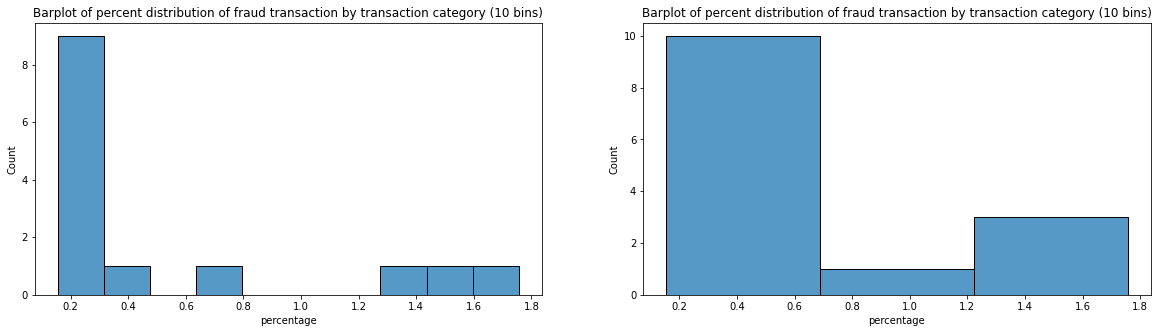

In [481]:
# Barplot of distribution of fraud transaction by transaction category
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_category_grouped[merged_category_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Barplot of percent distribution of fraud transaction by transaction category (10 bins)')
histplot_2 = sns.histplot(merged_category_grouped[merged_category_grouped.is_fraud == 1].percentage, bins=3, ax=axes[1])
axes[1].set_title('Barplot of percent distribution of fraud transaction by transaction category (10 bins)');

In [482]:
# List of high risk transaction category
high_risk_category = merged_category_grouped[(merged_category_grouped.is_fraud == 1) & (merged_category_grouped.percentage >= 1)].category.to_list()

По результатам анализа признака категорий транзакций в зависимости от метки о мошенничестве сделаны следующие выводы:
- Максимальный процент мошеннических транзакций наблюдается в категории интернет покупок (1,76% от общего числа транзакций по данной категории)
- Наименьший процент мошеннических транзакций наблюдается в категории health_fitness (0,15% от общего числа транзакций по данной категории)

Для категорий транзакций с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

## 3.7 Merchant feature analysis

In [483]:
# Descriptive statistics of merchant feature
pre_processed_data.merchant.describe()

count               1296675
unique                  693
top       fraud_Kilback LLC
freq                   4403
Name: merchant, dtype: object

In [484]:
# Merchant feature analysis
overal_merchant_grouped = pre_processed_data[['merchant', 'trans_num']].groupby(['merchant']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_merchant_grouped = pre_processed_data[['merchant', 'trans_num', 'is_fraud']].groupby(['merchant', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_merchant_grouped = fraud_merchant_grouped.merge(overal_merchant_grouped, how='inner', on='merchant')
merged_merchant_grouped['percentage'] = merged_merchant_grouped['fraud trans_count'] / merged_merchant_grouped['trans_count'] * 100
merged_merchant_grouped

,merchant,is_fraud,fraud trans_count,trans_count,percentage
0,fraud_Abbott-Rogahn,0,1841,1844,99.837310
1,fraud_Abbott-Rogahn,1,3,1844,0.162690
2,fraud_Abbott-Steuber,0,1757,1763,99.659671
3,fraud_Abbott-Steuber,1,6,1763,0.340329
4,fraud_Abernathy and Sons,0,1747,1751,99.771559
...,...,...,...,...,...
1367,fraud_Ziemann-Waters,1,6,1695,0.353982
1368,"fraud_Zieme, Bode and Dooley",0,2552,2560,99.687500
1369,"fraud_Zieme, Bode and Dooley",1,8,2560,0.312500
1370,fraud_Zulauf LLC,0,1781,1783,99.887830


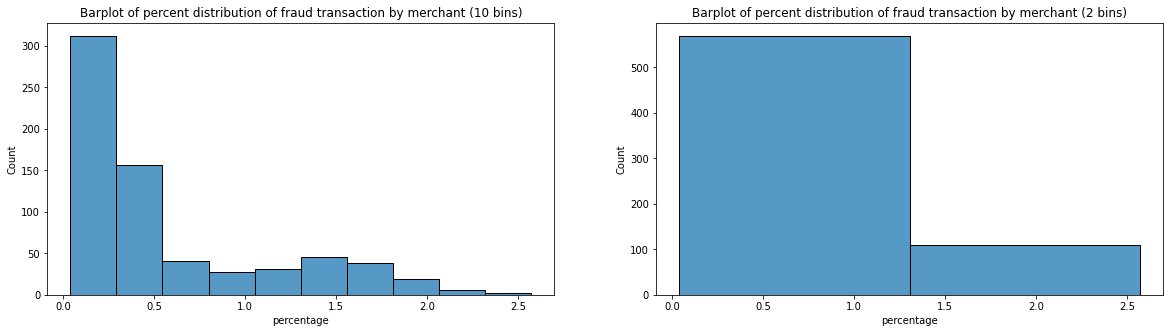

In [485]:
# Barplot of distribution of fraud transaction by merchant
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_merchant_grouped[merged_merchant_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Barplot of percent distribution of fraud transaction by merchant (10 bins)')
histplot_2 = sns.histplot(merged_merchant_grouped[merged_merchant_grouped.is_fraud == 1].percentage, bins=2, ax=axes[1])
axes[1].set_title('Barplot of percent distribution of fraud transaction by merchant (2 bins)');

In [486]:
# List of high risk merchant
high_risk_merchant = merged_merchant_grouped[(merged_merchant_grouped.is_fraud == 1) & (merged_merchant_grouped.percentage >= 1)].merchant.to_list()

По результатам анализа признака наименований продавца в зависимости от метки о мошенничестве сделаны следующие выводы:
- Максимальный процент мошеннических транзакций наблюдается у продавца fraud_Kozey-Boehm (2,6% от общего числа транзакций по данному продавцу)
- Для 145 продавцов наблюдается процент мошеннических операций > 1% от общего числа транзакций по данным продавцам

Для продавцов с высоким процентом мошеннических опраций необходимо принятие дополнительных мер по профилактике мошенничества.

## 3.8 Transaction time feature analysis

In [487]:
# Transaction month of the year feature analysis
overal_month_grouped = pre_processed_data[['trans_month_of_year', 'trans_num']].groupby(['trans_month_of_year']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_month_grouped = pre_processed_data[['trans_month_of_year', 'trans_num', 'is_fraud']].groupby(['trans_month_of_year', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_month_grouped = fraud_month_grouped.merge(overal_month_grouped, how='inner', on='trans_month_of_year')
merged_month_grouped['percentage'] = merged_month_grouped['fraud trans_count'] / merged_month_grouped['trans_count'] * 100

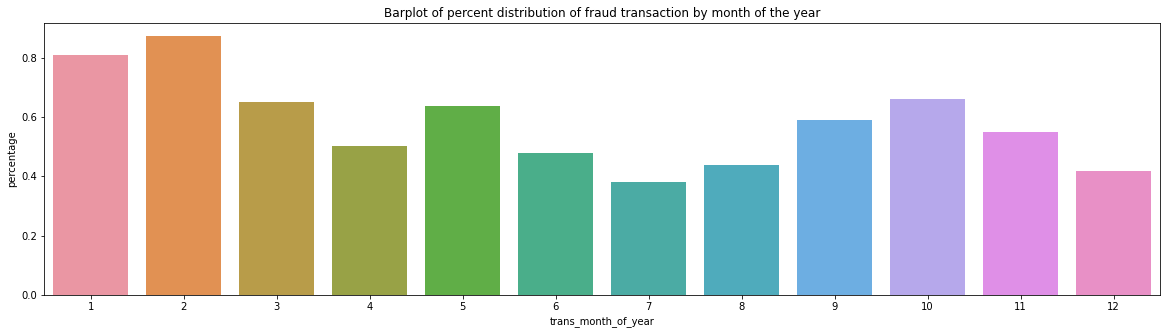

In [488]:
# Barplot of distribution of fraud transaction by month of the year
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

histplot = sns.barplot(data=merged_month_grouped[merged_month_grouped.is_fraud == 1], x='trans_month_of_year', y='percentage')
histplot.set_title('Barplot of percent distribution of fraud transaction by month of the year');

In [489]:
# Transaction day of week feature analysis
overal_day_grouped = pre_processed_data[['trans_day_of_week', 'trans_num']].groupby(['trans_day_of_week']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_day_grouped = pre_processed_data[['trans_day_of_week', 'trans_num', 'is_fraud']].groupby(['trans_day_of_week', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_day_grouped = fraud_day_grouped.merge(overal_day_grouped, how='inner', on='trans_day_of_week')
merged_day_grouped['percentage'] = merged_day_grouped['fraud trans_count'] / merged_day_grouped['trans_count'] * 100

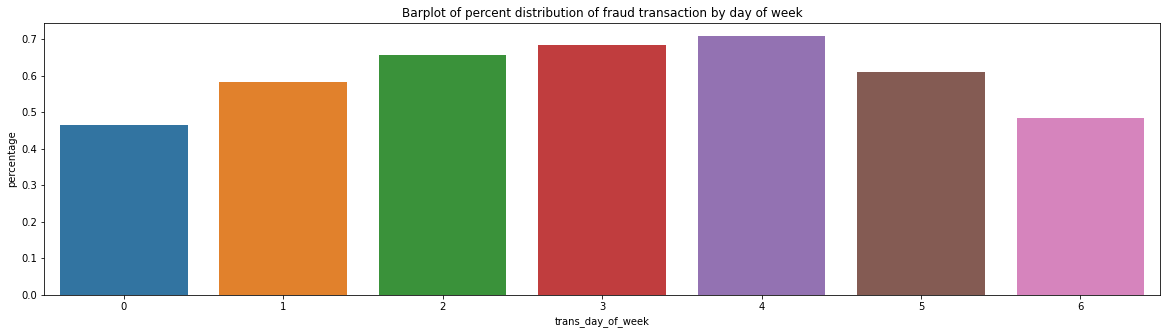

In [490]:
# Barplot of distribution of fraud transaction by day of week
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

histplot = sns.barplot(data=merged_day_grouped[merged_day_grouped.is_fraud == 1], x='trans_day_of_week', y='percentage')
histplot.set_title('Barplot of percent distribution of fraud transaction by day of week');

In [491]:
# Transaction hour feature analysis
overal_hour_grouped = pre_processed_data[['trans_hour', 'trans_num']].groupby(['trans_hour']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_hour_grouped = pre_processed_data[['trans_hour', 'trans_num', 'is_fraud']].groupby(['trans_hour', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_hour_grouped = fraud_hour_grouped.merge(overal_hour_grouped, how='inner', on='trans_hour')
merged_hour_grouped['percentage'] = merged_hour_grouped['fraud trans_count'] / merged_hour_grouped['trans_count'] * 100

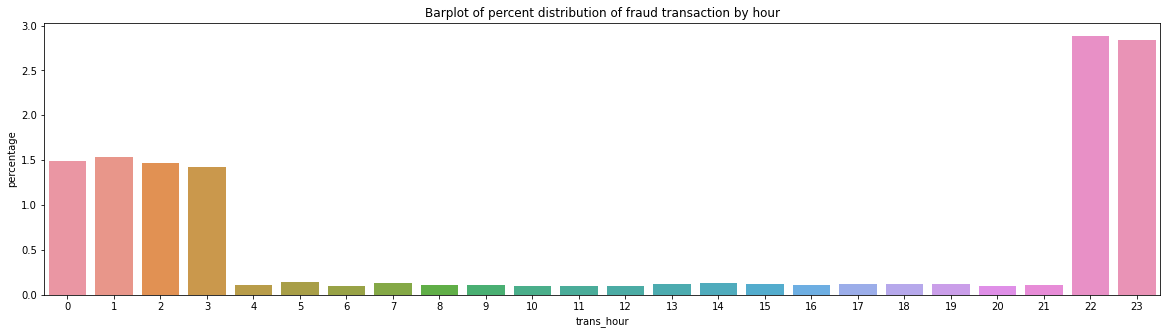

In [492]:
# Barplot of distribution of fraud transaction by hour
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

histplot = sns.barplot(data=merged_hour_grouped[merged_hour_grouped.is_fraud == 1], x='trans_hour', y='percentage')
histplot.set_title('Barplot of percent distribution of fraud transaction by hour');

По результатам анализа признака времени совершения транзакции от метки о мошенничестве сделаны следующие выводы:
- Максимальный процент мошеннических транзакций наблюдается в феврале месяце (0,87% от общего числа транзакций в данном месяце)
- Максимальный процент мошеннических транзакций наблюдается в по пятницам (0,71% от общего числа транзакций по данному дню недели)
- Максимальный процент мошеннических транзакций наблюдается в в вечерние часы - 22-23 часа (2,88-2,84% соответственно от общего числа транзакций в данные часы суток)


## 3.9 Geographic features analysis

In [493]:
# Descriptive statistics of city feature
pre_processed_data.city.describe()

count        1296675
unique           894
top       Birmingham
freq            5617
Name: city, dtype: object

In [494]:
# Descriptive statistics of zip feature
pre_processed_data.zip.describe()

count     1296675
unique        970
top         73754
freq         3646
Name: zip, dtype: object

In [495]:
# Transaction city feature analysis
overal_city_grouped = pre_processed_data[['city', 'trans_num']].groupby(['city']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_city_grouped = pre_processed_data[['city', 'trans_num', 'is_fraud']].groupby(['city', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_city_grouped = fraud_city_grouped.merge(overal_city_grouped, how='inner', on='city')
merged_city_grouped['percentage'] = merged_city_grouped['fraud trans_count'] / merged_city_grouped['trans_count'] * 100

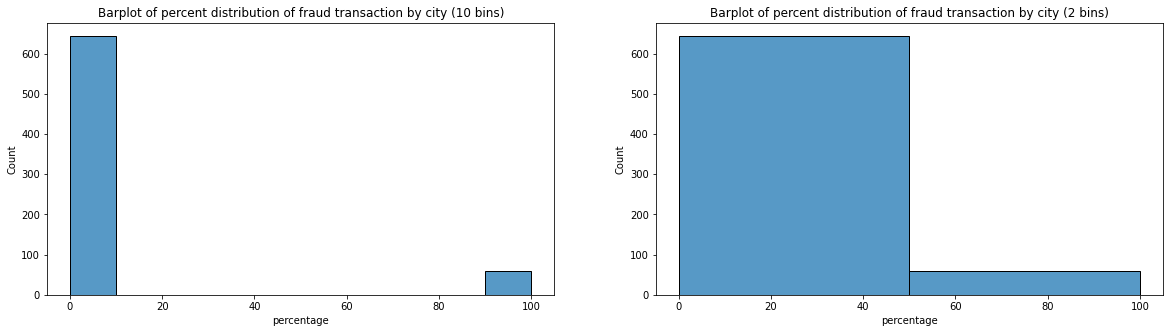

In [496]:
# Barplot of distribution of fraud transaction by city
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_city_grouped[merged_city_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Barplot of percent distribution of fraud transaction by city (10 bins)')
histplot_2 = sns.histplot(merged_city_grouped[merged_city_grouped.is_fraud == 1].percentage, bins=2, ax=axes[1])
axes[1].set_title('Barplot of percent distribution of fraud transaction by city (2 bins)');

In [497]:
# List of high risk cities
high_risk_cities = merged_city_grouped[(merged_city_grouped.is_fraud == 1) & (merged_city_grouped.percentage >= 90)].city.to_list()

In [498]:
# Transaction zip code feature analysis
overal_zip_grouped = pre_processed_data[['zip', 'trans_num']].groupby(['zip']).count().reset_index().rename(columns={'trans_num':'trans_count'})
fraud_zip_grouped = pre_processed_data[['zip', 'trans_num', 'is_fraud']].groupby(['zip', 'is_fraud']).count().reset_index().rename(columns={'trans_num':'fraud trans_count'})
merged_zip_grouped = fraud_zip_grouped.merge(overal_zip_grouped, how='inner', on='zip')
merged_zip_grouped['percentage'] = merged_zip_grouped['fraud trans_count'] / merged_zip_grouped['trans_count'] * 100

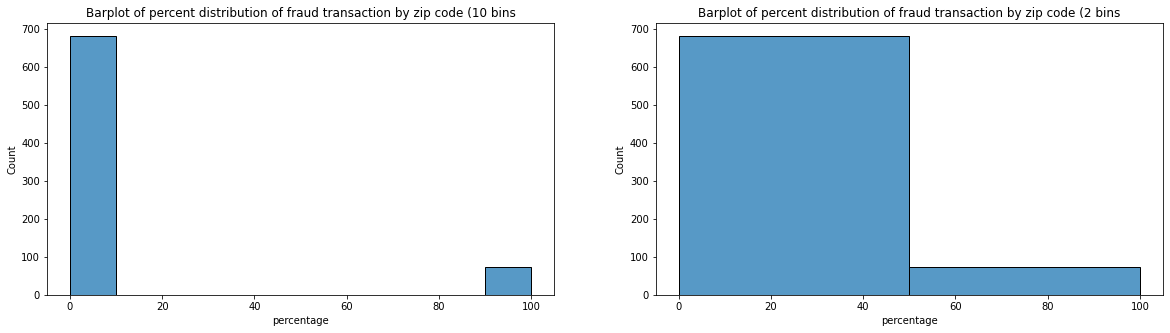

In [499]:
# Barplot of distribution of fraud transaction by zip
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
histplot_10 = sns.histplot(merged_zip_grouped[merged_zip_grouped.is_fraud == 1].percentage, bins=10, ax=axes[0])
axes[0].set_title('Barplot of percent distribution of fraud transaction by zip code (10 bins')
histplot_2 = sns.histplot(merged_zip_grouped[merged_zip_grouped.is_fraud == 1].percentage, bins=2, ax=axes[1])
axes[1].set_title('Barplot of percent distribution of fraud transaction by zip code (2 bins');

In [500]:
# List of high risk zip code
high_risk_zip = merged_zip_grouped[(merged_zip_grouped.is_fraud == 1) & (merged_zip_grouped.percentage >= 90)].zip.to_list()

По результатам анализа географических признаков совершения транзакции от метки о мошенничестве сделаны следующие выводы:
- В 70 городах наблюдается высокий риск мошеннических транзакций (более 90% от общего числа транзакций по данным городам)
- Для 88 почтовых кодов наблюдается высокий риск мошеннических транзакций (более 90% от общего числа транзакций по данным почтовым кодам)

Города и почтовые коды с повышенным риском мошеннических операций в пристально контроле

# 4. Feature Engineering

## 4.1 Data Cleaning

In [501]:
# Data duplicates analysis
duplicates = pre_processed_data[pre_processed_data.duplicated(subset=pre_processed_data.columns)]
pre_processed_data = pre_processed_data.drop_duplicates()

# Number of deleted duplicates
display(duplicates.shape[0])

0

In [502]:
# Cheking for missing values
null_cols = pre_processed_data.isnull().sum()
null_cols = null_cols[null_cols > 0]

# Number of missing values
display(null_cols)

Series([], dtype: int64)

In [503]:
# Deleting amt outliers 
amt_outlies_mask = pre_processed_data.amt > 1500
pre_processed_data = pre_processed_data.drop(pre_processed_data[amt_outlies_mask].index, axis=0)

## 4.2 Feature Creation

In [504]:
def add_high_risk_job(data, high_risk_list):
    data['high_risk_job'] = data['job'].apply(lambda x: 1 if x in high_risk_list else 0)
    data['job'] = data['job'].apply(lambda x: x if x in high_risk_list else 'Other')
    return data

def add_high_risk_merchant(data, high_risk_list):
    data['high_risk_merchant'] = data['merchant'].apply(lambda x: 1 if x in high_risk_list else 0)
    data['merchant'] = data['merchant'].apply(lambda x: x if x in high_risk_list else 'Other')
    return data

def add_high_risk_city(data, high_risk_list):
    data['high_risk_city'] = data['city'].apply(lambda x: 1 if x in high_risk_list else 0)
    data['city'] = data['city'].apply(lambda x: x if x in high_risk_list else 'Other')
    return data

def add_high_risk_zip(data, high_risk_list):
    data['high_risk_zip'] = data['zip'].apply(lambda x: 1 if x in high_risk_list else 0)
    data['zip'] = data['zip'].apply(lambda x: x if x in high_risk_list else 'Other')
    return data

In [505]:
pre_processed_data = add_high_risk_job(pre_processed_data, high_risk_job)
pre_processed_data = add_high_risk_merchant(pre_processed_data, high_risk_merchant)
pre_processed_data = add_high_risk_city(pre_processed_data, high_risk_cities)
pre_processed_data = add_high_risk_zip(pre_processed_data, high_risk_zip)

## 4.3 Feature Encoding

In [506]:
avoid_list = ['cc_num', 'first', 'last', 'street', 'state', 'lat', 'long', 'city_pop', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']
processed_data = pre_processed_data.drop(avoid_list, axis=1)

In [507]:
# Number of unique values analysis
for col in processed_data.columns:
    display(f'Количество уникальных значение признака - {col}: {processed_data[col].nunique()}')

'Количество уникальных значение признака - merchant: 146'

'Количество уникальных значение признака - category: 14'

'Количество уникальных значение признака - amt: 51635'

'Количество уникальных значение признака - gender: 2'

'Количество уникальных значение признака - city: 59'

'Количество уникальных значение признака - zip: 74'

'Количество уникальных значение признака - job: 20'

'Количество уникальных значение признака - is_fraud: 2'

'Количество уникальных значение признака - trans_month_of_year: 12'

'Количество уникальных значение признака - trans_day_of_week: 7'

'Количество уникальных значение признака - trans_hour: 24'

'Количество уникальных значение признака - age_of_cardholder: 83'

'Количество уникальных значение признака - age_group: 4'

'Количество уникальных значение признака - high_risk_job: 2'

'Количество уникальных значение признака - high_risk_merchant: 2'

'Количество уникальных значение признака - high_risk_city: 2'

'Количество уникальных значение признака - high_risk_zip: 2'

The principle of feature encoding:

- For ordinal features - OrdinalEncoding
- For nominal features (if less than 15) - OneHotEncoding
- For nominal features (if more than 15) - BinaryEncoding

In [508]:
nom_features_15 = ['gender', 'age_group', 'category']
nom_features_15_more = ['merchant', 'city', 'zip', 'job']

In [509]:
# Encoding nominal features less than 15 nununique
encoder = ce.OneHotEncoder(cols=nom_features_15)
type_bin = encoder.fit_transform(processed_data[nom_features_15])
processed_data = pd.concat([processed_data, type_bin], axis=1)

In [510]:
# Encoding nominal features 15 and more nununique
#encoder = ce.BinaryEncoder(cols=nom_features_15_more)
#type_bin = encoder.fit_transform(processed_data[nom_features_15_more])
#processed_data = pd.concat([processed_data, type_bin], axis=1)

In [511]:
processed_data = processed_data.drop(nom_features_15, axis=1)
processed_data = processed_data.drop(nom_features_15_more, axis=1)

## 4.4 Feature Transformation

In [512]:
# Scaling of numerical features
cols_to_norm = ['amt', 'age_of_cardholder']

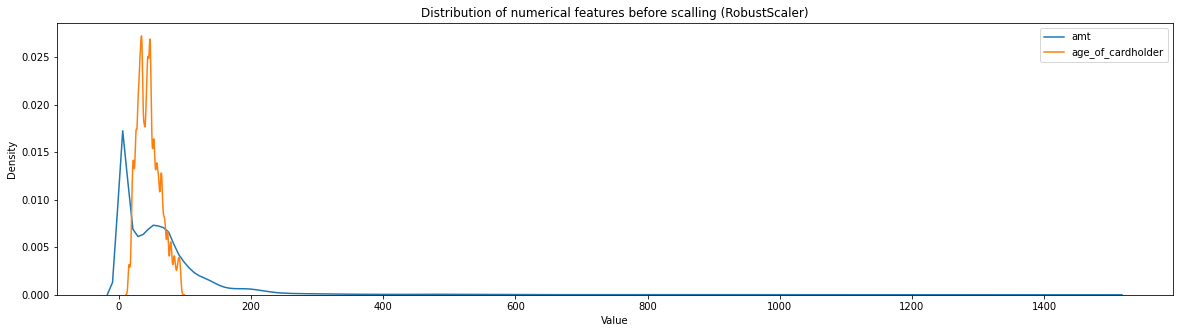

In [513]:
# Visualization numeric feature distribution before scaling
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
for col in cols_to_norm:
    sns.kdeplot(processed_data[col], ax=axes)

axes.set_title('Distribution of numerical features before scalling (RobustScaler)')
axes.set_xlabel('Value')
plt.legend(cols_to_norm)

In [514]:
# Features scaling
processed_data_norm = processed_data[cols_to_norm].copy()

rs_scaler = preprocessing.RobustScaler()
processed_data_norm_rs = rs_scaler.fit_transform(processed_data_norm)
processed_data_norm_rs = pd.DataFrame(processed_data_norm_rs, columns=cols_to_norm)

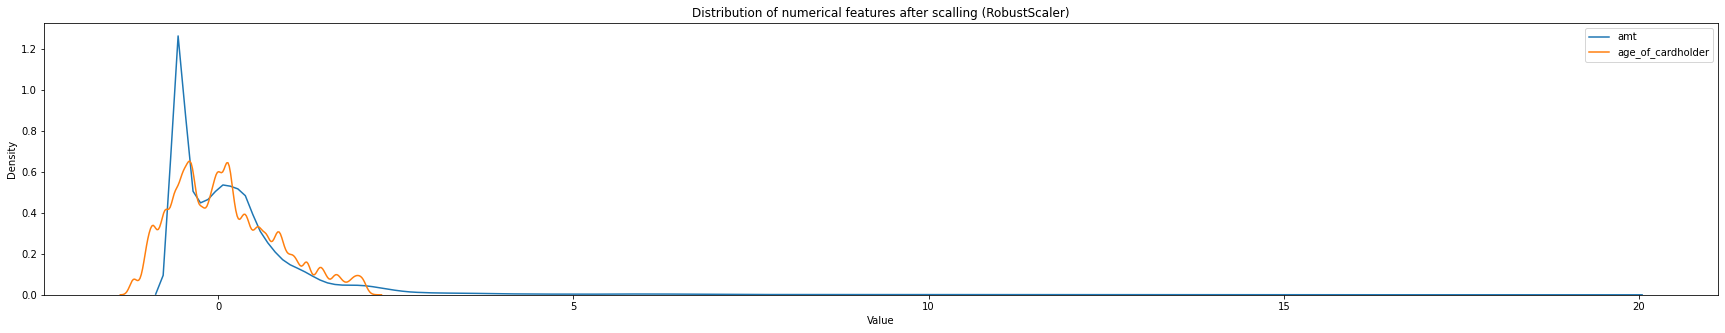

In [515]:
# Visualization numeric feature distribution after scaling
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 5))
for col in cols_to_norm:
    sns.kdeplot(processed_data_norm_rs[col], ax=axes)

axes.set_title('Distribution of numerical features after scalling (RobustScaler)')
axes.set_xlabel('Value')
plt.legend(cols_to_norm)

In [516]:
processed_data.reset_index(drop=True, inplace=True)
processed_data_norm_rs.reset_index(drop=True, inplace=True)

processed_data = processed_data.drop(cols_to_norm, axis=1)
processed_data = pd.concat([processed_data, processed_data_norm_rs[cols_to_norm]], axis=1)

## 4.5 Feature Selection

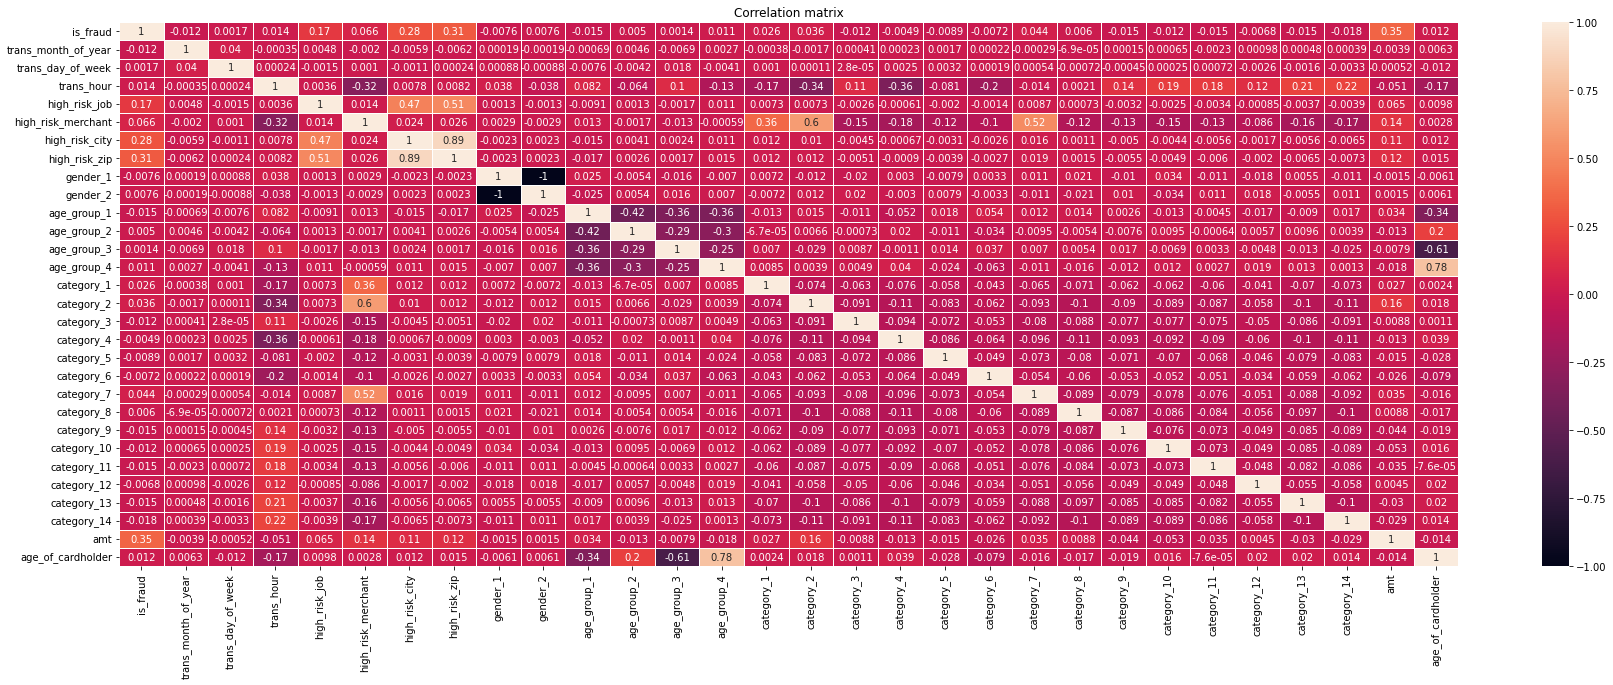

In [517]:
# Correlation analysis
fig, axes = plt.subplots(ncols=1, figsize=(30, 10))
sns.heatmap(processed_data.corr(), annot=True, linewidths=0.5)
axes.set_title('Correlation matrix');

In [518]:
# Removal of multicolinear features
cols_to_drop = ['gender_2', 'high_risk_city']
processed_data = processed_data.drop(cols_to_drop, axis=1)

In [519]:
# Numeric features list
num_cols = ['trans_month_of_year', 'trans_day_of_week', 'trans_hour', 'amt', 'age_of_cardholder']

# Categorial features list
cat_cols = ['high_risk_job', 'high_risk_zip',
       'gender_1', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4'
]

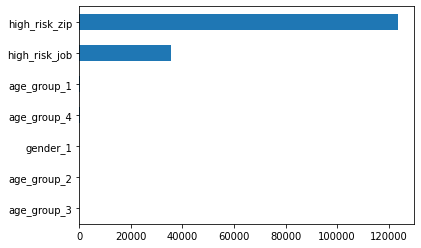

In [520]:
# Оценка значимости категориальных признаков
imp_cat = pd.Series(chi2(processed_data[cat_cols], processed_data['is_fraud'])[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

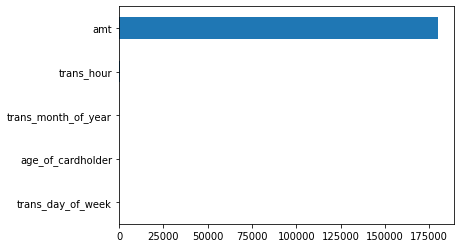

In [521]:
# Оценка значимости непрерывных признаков
imp_num = pd.Series(f_classif(processed_data[num_cols], processed_data['is_fraud'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

# 4. Model Construction

In [522]:
# Train data features and target variable split
X_train = processed_data.drop(['is_fraud'], axis=1)
y_train = processed_data['is_fraud']

In [523]:
# Test data performing
# Test data pre-processing
test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])
test_data['dob'] = pd.to_datetime(test_data['dob'])
test_data['zip'] = test_data['zip'].astype(dtype='string')

# Feature engineering
test_data = add_datetime_features(test_data)
test_data['age_group'] = test_data['age_of_cardholder'].apply(add_age_group)
test_data = add_high_risk_job(test_data, high_risk_job)
test_data = add_high_risk_merchant(test_data, high_risk_merchant)
test_data = add_high_risk_city(test_data, high_risk_cities)
test_data = add_high_risk_zip(test_data, high_risk_zip)

# Feature encoding
encoder = ce.OneHotEncoder(cols=nom_features_15)
type_bin = encoder.fit_transform(test_data[nom_features_15])
test_data = pd.concat([test_data, type_bin], axis=1)
test_data = test_data.drop(nom_features_15, axis=1)
test_data = test_data.drop(nom_features_15_more, axis=1)

# Feature scaling
test_data_norm_rs = rs_scaler.transform(test_data[cols_to_norm])
test_data_norm_rs = pd.DataFrame(test_data_norm_rs, columns=cols_to_norm)
test_data.drop(cols_to_norm, axis=1, inplace=True)
test_data = pd.concat([test_data.reset_index(drop=True), test_data_norm_rs[cols_to_norm].reset_index(drop=True)], axis=1)

# Feature selection
test_data = test_data[processed_data.columns.to_list()]

# Train data features and target variable split
X_test = test_data.drop(['is_fraud'], axis=1)
y_test = test_data['is_fraud']

## Baseline - Logistic Regression

In [524]:
# Linear model
lr_model_name = 'Baseline - LogisticRegression'
lr = LogisticRegression(random_state=RANDOM_NUM)
lr_model = lr.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [525]:
# Getting model evalution statistic
model_evalution_df = pd.DataFrame(columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])

def add_model_evalution_stat(model_name, model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, model_evalution_df):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred, average='weighted')
    precision = metrics.precision_score(y_test, y_test_pred)
    recall = metrics.recall_score(y_test, y_test_pred)
    model_evalutions_stats = [model_name, train_score, test_score, accuracy, f1_score, precision, recall]
    model_evalution_dict = {model_evalution_df.columns[i]:model_evalutions_stats[i] for i in range(len(model_evalutions_stats))}
    model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)
    return model_evalution_df

In [526]:
# Adding baseline model evalution statisctic
model_evalution_df = add_model_evalution_stat(lr_model_name, lr_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, model_evalution_df)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_12540\3354413077.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


In [527]:
model_evalution_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Baseline - LogisticRegression,0.994957,0.994154,0.994154,0.994318,0.270192,0.302564
